###Setup & dependencies


In [ ]:
!apt update
!apt install -y megatools

In [1]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


###Download dataset from mega link

In [5]:
!megadl 'mega download link'

Downloaded Seeds_Dataset.zip


###Mount google drive for the dataset (Alternative)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Path to ZIP file in Drive
zip_path = "/content/drive/MyDrive/dataset/ML Project Dataset/Seeds_Dataset.zip"

Mounted at /content/drive


###Unzip the file

In [3]:
!unzip -q "$zip_path" -d /content/seeds_dataset

###Create train/val/test split

In [11]:
import os, glob, random, shutil
from pathlib import Path

random.seed(42)

SRC = '/content/seeds_dataset'   # Path with all 14 class folders
OUT = '/content/seeds_dataset_split'  # Will be created

ratios = (0.7, 0.15, 0.15)  # train, val, test

classes = [
    'Bitter melon', 'Bottle gourd', 'Carrot', 'Cauliflower', 'Chili',
    'Coriander leaves', 'Cucumber', 'Hyacinth bean', 'Malabar spinach',
    'Onion', 'Radish', 'Spinach', 'Tomato', 'Water spinach'
]

for cls in classes:
    src_dir = os.path.join(SRC, cls)

    # Collect all common image files in any case
    imgs = []
    for ext in ('*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG'):
        imgs.extend(glob.glob(os.path.join(src_dir, ext)))

    if len(imgs) == 0:
        print(f"Warning: No images found in {src_dir}")
        continue  # Skip this class if empty

    random.shuffle(imgs)
    n = len(imgs)
    ntrain = int(n * ratios[0])
    nval = int(n * ratios[1])

    train_files = imgs[:ntrain]
    val_files = imgs[ntrain:ntrain+nval]
    test_files = imgs[ntrain+nval:]

    for split, files in [('train', train_files), ('val', val_files), ('test', test_files)]:
        out_dir = os.path.join(OUT, split, cls)
        os.makedirs(out_dir, exist_ok=True)
        for f in files:
            shutil.copy(f, out_dir)

print("Done. Created dataset under:", OUT)
DATA_DIR = OUT


Done. Created dataset under: /content/seeds_dataset_split


###Create tf.data pipelines + augmentation

In [12]:
import tensorflow as tf
from tensorflow.keras import layers

IMG_SIZE = (224, 224)   # good default for these models
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'train'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    seed=42,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'val'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    seed=42,
    shuffle=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'test'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    seed=42,
    shuffle=False
)

# Get class names
class_names = train_ds.class_names
print("Classes found:", class_names)

# Prefetch
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Simple augmentation layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
    layers.RandomContrast(0.08),
])

Found 5743 files belonging to 14 classes.
Found 1709 files belonging to 14 classes.
Found 1704 files belonging to 14 classes.
Classes found: ['Bitter melon', 'Bottle gourd', 'Carrot', 'Cauliflower', 'Chili', 'Coriander leaves', 'Cucumber', 'Hyacinth bean', 'Malabar spinach', 'Onion', 'Radish', 'Spinach', 'Tomato', 'Water spinach']


###Utility: build model function (transfer learning)

In [16]:
def build_transfer_model(base_model_name, input_shape=IMG_SIZE+(3,), n_classes=14, base_trainable=False):
    """
    base_model_name: one of 'EfficientNetB0', 'MobileNetV3Large', 'ResNet50V2'
    base_trainable: whether to unfreeze base for fine-tuning
    """
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    if base_model_name == 'EfficientNetB0':
        preproc = tf.keras.applications.efficientnet.preprocess_input
        base = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    elif base_model_name == 'MobileNetV3Large':
        preproc = tf.keras.applications.mobilenet_v3.preprocess_input
        base = tf.keras.applications.MobileNetV3Large(include_top=False, input_shape=input_shape, weights='imagenet')
    elif base_model_name == 'ResNet50V2':
        preproc = tf.keras.applications.resnet_v2.preprocess_input
        base = tf.keras.applications.ResNet50V2(include_top=False, input_shape=input_shape, weights='imagenet')
    else:
        raise ValueError("Unknown model")

    x = layers.Lambda(preproc)(x)
    x = base(x, training=False)   # keep batchnorm in inference mode when base frozen
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    # FIXED: Changed to softmax activation for multi-class classification
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)

    # Freeze or unfreeze base as requested
    base.trainable = base_trainable

    return model, base

###Training helper (freeze-then-finetune)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def compile_and_train(model, train_ds, val_ds, lr=1e-3, epochs=10, model_name='model'):
    # FIXED: Changed to sparse_categorical_crossentropy for multi-class classification
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
        ModelCheckpoint(f"{model_name}.h5", save_best_only=True, monitor='val_loss')
    ]
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)
    return history

###Train three models (steps to run sequentially)

In [18]:
# 1) EfficientNetB0
model_e, base_e = build_transfer_model('EfficientNetB0', base_trainable=False)
print(model_e.summary())
history_e = compile_and_train(model_e, train_ds, val_ds, lr=1e-3, epochs=12, model_name='effnetb0_stage1')

# Fine-tune: unfreeze last some layers
base_e.trainable = True
# Optionally freeze first layers and unfreeze last block
for layer in base_e.layers[:-30]:
    layer.trainable = False
for layer in base_e.layers[-30:]:
    layer.trainable = True

history_e_ft = compile_and_train(model_e, train_ds, val_ds, lr=1e-5, epochs=8, model_name='effnetb0_finetune')

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,215,345 (16.08 MB)

 Trainable params: 165,774 (647.55 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

None
Epoch 1/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 967ms/step - accuracy: 0.7329 - loss: 0.9353

180/180 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.7337 - loss: 0.9325 - val_accuracy: 0.9789 - val_loss: 0.0704 - learning_rate: 0.0010
Epoch 2/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 947ms/step - accuracy: 0.9737 - loss: 0.0870

180/180 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.9737 - loss: 0.0870 - val_accuracy: 0.9895 - val_loss: 0.0399 - learning_rate: 0.0010
Epoch 3/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 940ms/step - accuracy: 0.9847 - loss: 0.0562

180/180 ━━━━━━━━━━━━━━━━━━━━ 291s 1s/step - accuracy: 0.9847 - loss: 0.0562 - val_accuracy: 0.9877 - val_loss: 0.0364 - learning_rate: 0.0010
Epoch 4/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 954ms/step - accuracy: 0.9891 - loss: 0.0396

180/180 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.9891 - loss: 0.0396 - val_accuracy: 0.9947 - val_loss: 0.0202 - learning_rate: 0.0010
Epoch 5/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - accuracy: 0.9871 - loss: 0.0395 - val_accuracy: 0.9877 - val_loss: 0.0330 - learning_rate: 0.0010
Epoch 6/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - accuracy: 0.9900 - loss: 0.0315

180/180 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.9900 - loss: 0.0315 - val_accuracy: 0.9959 - val_loss: 0.0125 - learning_rate: 0.0010
Epoch 7/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.9912 - loss: 0.0299 - val_accuracy: 0.9947 - val_loss: 0.0173 - learning_rate: 0.0010
Epoch 8/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.9906 - loss: 0.0265 - val_accuracy: 0.9824 - val_loss: 0.0463 - learning_rate: 0.0010
Epoch 9/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.9929 - loss: 0.0243 - val_accuracy: 0.9941 - val_loss: 0.0208 - learning_rate: 0.0010
Epoch 10/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.9901 - loss: 0.0249 - val_accuracy: 0.9947 - val_loss: 0.0160 - learning_rate: 5.0000e-04
Epoch 11/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 946ms/step - accuracy: 0.9926 - loss: 0.0236

180/180 ━━━━━━━━━━━━━━━━━━━━ 294s 1s/step - accuracy: 0.9926 - loss: 0.0236 - val_accuracy: 0.9971 - val_loss: 0.0111 - learning_rate: 5.0000e-04
Epoch 12/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - accuracy: 0.9914 - loss: 0.0204

180/180 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.9914 - loss: 0.0204 - val_accuracy: 0.9971 - val_loss: 0.0081 - learning_rate: 5.0000e-04
Epoch 1/8
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.9422 - loss: 0.2137

180/180 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.9422 - loss: 0.2135 - val_accuracy: 0.9947 - val_loss: 0.0208 - learning_rate: 1.0000e-05
Epoch 2/8
180/180 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - accuracy: 0.9681 - loss: 0.1132 - val_accuracy: 0.9941 - val_loss: 0.0226 - learning_rate: 1.0000e-05
Epoch 3/8
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 944ms/step - accuracy: 0.9820 - loss: 0.0765

180/180 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.9820 - loss: 0.0765 - val_accuracy: 0.9941 - val_loss: 0.0205 - learning_rate: 1.0000e-05
Epoch 4/8
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 942ms/step - accuracy: 0.9778 - loss: 0.0740

180/180 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - accuracy: 0.9778 - loss: 0.0739 - val_accuracy: 0.9953 - val_loss: 0.0188 - learning_rate: 1.0000e-05
Epoch 5/8
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - accuracy: 0.9883 - loss: 0.0494

180/180 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.9883 - loss: 0.0494 - val_accuracy: 0.9959 - val_loss: 0.0166 - learning_rate: 1.0000e-05
Epoch 6/8
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - accuracy: 0.9877 - loss: 0.0424

180/180 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.9876 - loss: 0.0424 - val_accuracy: 0.9971 - val_loss: 0.0135 - learning_rate: 1.0000e-05
Epoch 7/8
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 937ms/step - accuracy: 0.9890 - loss: 0.0418

180/180 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.9890 - loss: 0.0418 - val_accuracy: 0.9971 - val_loss: 0.0132 - learning_rate: 1.0000e-05
Epoch 8/8
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - accuracy: 0.9892 - loss: 0.0390

180/180 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.9892 - loss: 0.0390 - val_accuracy: 0.9971 - val_loss: 0.0107 - learning_rate: 1.0000e-05


In [19]:
# 2) MobileNetV3Large
model_m, base_m = build_transfer_model('MobileNetV3Large', base_trainable=False)
history_m = compile_and_train(model_m, train_ds, val_ds, lr=1e-3, epochs=12, model_name='mobilenetv3_stage1')

base_m.trainable = True
for layer in base_m.layers[:-30]:
    layer.trainable = False
history_m_ft = compile_and_train(model_m, train_ds, val_ds, lr=1e-5, epochs=8, model_name='mobilenetv3_finetune')

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.6798 - loss: 1.0479

180/180 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.6807 - loss: 1.0448 - val_accuracy: 0.9514 - val_loss: 0.1596 - learning_rate: 0.0010
Epoch 2/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - accuracy: 0.9662 - loss: 0.1116

180/180 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.9662 - loss: 0.1116 - val_accuracy: 0.9696 - val_loss: 0.0816 - learning_rate: 0.0010
Epoch 3/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/step - accuracy: 0.9816 - loss: 0.0592

180/180 ━━━━━━━━━━━━━━━━━━━━ 248s 1s/step - accuracy: 0.9816 - loss: 0.0592 - val_accuracy: 0.9748 - val_loss: 0.0621 - learning_rate: 0.0010
Epoch 4/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.9872 - loss: 0.0492

180/180 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.9872 - loss: 0.0492 - val_accuracy: 0.9813 - val_loss: 0.0506 - learning_rate: 0.0010
Epoch 5/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.9847 - loss: 0.0454

180/180 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - accuracy: 0.9847 - loss: 0.0454 - val_accuracy: 0.9941 - val_loss: 0.0189 - learning_rate: 0.0010
Epoch 6/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.9907 - loss: 0.0331 - val_accuracy: 0.9854 - val_loss: 0.0407 - learning_rate: 0.0010
Epoch 7/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.9882 - loss: 0.0355 - val_accuracy: 0.9906 - val_loss: 0.0312 - learning_rate: 0.0010
Epoch 8/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.9901 - loss: 0.0313

180/180 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.9901 - loss: 0.0313 - val_accuracy: 0.9936 - val_loss: 0.0170 - learning_rate: 0.0010
Epoch 9/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 294s 1s/step - accuracy: 0.9896 - loss: 0.0323 - val_accuracy: 0.9930 - val_loss: 0.0191 - learning_rate: 0.0010
Epoch 10/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.9903 - loss: 0.0267 - val_accuracy: 0.9901 - val_loss: 0.0253 - learning_rate: 0.0010
Epoch 11/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.9948 - loss: 0.0185 - val_accuracy: 0.9889 - val_loss: 0.0263 - learning_rate: 0.0010
Epoch 12/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.9926 - loss: 0.0236

180/180 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.9927 - loss: 0.0236 - val_accuracy: 0.9936 - val_loss: 0.0153 - learning_rate: 5.0000e-04
Epoch 1/8
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.9394 - loss: 0.1861

180/180 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.9394 - loss: 0.1860 - val_accuracy: 0.9936 - val_loss: 0.0145 - learning_rate: 1.0000e-05
Epoch 2/8
180/180 ━━━━━━━━━━━━━━━━━━━━ 291s 1s/step - accuracy: 0.9745 - loss: 0.0848 - val_accuracy: 0.9936 - val_loss: 0.0180 - learning_rate: 1.0000e-05
Epoch 3/8
180/180 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.9808 - loss: 0.0615 - val_accuracy: 0.9936 - val_loss: 0.0212 - learning_rate: 1.0000e-05
Epoch 4/8
180/180 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.9861 - loss: 0.0474 - val_accuracy: 0.9936 - val_loss: 0.0234 - learning_rate: 1.0000e-05
Epoch 5/8
180/180 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.9879 - loss: 0.0398 - val_accuracy: 0.9936 - val_loss: 0.0257 - learning_rate: 5.0000e-06
Epoch 6/8
180/180 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.9898 - loss: 0.0292 - val_accuracy: 0.9918 - val_loss: 0.0272 - learning_rate: 5.0000e-06


In [20]:
# 3) ResNet50V2
model_r, base_r = build_transfer_model('ResNet50V2', base_trainable=False)
history_r = compile_and_train(model_r, train_ds, val_ds, lr=1e-3, epochs=12, model_name='resnet50v2_stage1')

base_r.trainable = True
for layer in base_r.layers[:-30]:
    layer.trainable = False
history_r_ft = compile_and_train(model_r, train_ds, val_ds, lr=1e-5, epochs=8, model_name='resnet50v2_finetune')

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.6908 - loss: 1.0039

180/180 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.6916 - loss: 1.0011 - val_accuracy: 0.9666 - val_loss: 0.0966 - learning_rate: 0.0010
Epoch 2/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 934ms/step - accuracy: 0.9413 - loss: 0.1641

180/180 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.9413 - loss: 0.1640 - val_accuracy: 0.9696 - val_loss: 0.0842 - learning_rate: 0.0010
Epoch 3/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 934ms/step - accuracy: 0.9578 - loss: 0.1080

180/180 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.9578 - loss: 0.1080 - val_accuracy: 0.9783 - val_loss: 0.0592 - learning_rate: 0.0010
Epoch 4/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.9678 - loss: 0.0940

180/180 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.9677 - loss: 0.0940 - val_accuracy: 0.9842 - val_loss: 0.0468 - learning_rate: 0.0010
Epoch 5/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 933ms/step - accuracy: 0.9731 - loss: 0.0752

180/180 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - accuracy: 0.9731 - loss: 0.0752 - val_accuracy: 0.9871 - val_loss: 0.0360 - learning_rate: 0.0010
Epoch 6/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.9747 - loss: 0.0688 - val_accuracy: 0.9836 - val_loss: 0.0477 - learning_rate: 0.0010
Epoch 7/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.9817 - loss: 0.0601 - val_accuracy: 0.9778 - val_loss: 0.0615 - learning_rate: 0.0010
Epoch 8/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.9822 - loss: 0.0577 - val_accuracy: 0.9860 - val_loss: 0.0431 - learning_rate: 0.0010
Epoch 9/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - accuracy: 0.9828 - loss: 0.0451

180/180 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.9828 - loss: 0.0451 - val_accuracy: 0.9901 - val_loss: 0.0280 - learning_rate: 5.0000e-04
Epoch 10/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.9895 - loss: 0.0336 - val_accuracy: 0.9889 - val_loss: 0.0310 - learning_rate: 5.0000e-04
Epoch 11/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 294s 1s/step - accuracy: 0.9886 - loss: 0.0330 - val_accuracy: 0.9871 - val_loss: 0.0354 - learning_rate: 5.0000e-04
Epoch 12/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - accuracy: 0.9883 - loss: 0.0392

180/180 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - accuracy: 0.9883 - loss: 0.0392 - val_accuracy: 0.9936 - val_loss: 0.0216 - learning_rate: 5.0000e-04
Epoch 1/8
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.9204 - loss: 0.2536

180/180 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.9206 - loss: 0.2530 - val_accuracy: 0.9836 - val_loss: 0.0529 - learning_rate: 1.0000e-05
Epoch 2/8
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 944ms/step - accuracy: 0.9838 - loss: 0.0501

180/180 ━━━━━━━━━━━━━━━━━━━━ 291s 1s/step - accuracy: 0.9838 - loss: 0.0501 - val_accuracy: 0.9912 - val_loss: 0.0213 - learning_rate: 1.0000e-05
Epoch 3/8
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 937ms/step - accuracy: 0.9941 - loss: 0.0293

180/180 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.9941 - loss: 0.0293 - val_accuracy: 0.9941 - val_loss: 0.0122 - learning_rate: 1.0000e-05
Epoch 4/8
180/180 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - accuracy: 0.9937 - loss: 0.0238 - val_accuracy: 0.9941 - val_loss: 0.0170 - learning_rate: 1.0000e-05
Epoch 5/8
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - accuracy: 0.9947 - loss: 0.0172

180/180 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - accuracy: 0.9947 - loss: 0.0172 - val_accuracy: 0.9959 - val_loss: 0.0101 - learning_rate: 1.0000e-05
Epoch 6/8
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 984ms/step - accuracy: 0.9979 - loss: 0.0144

180/180 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.9979 - loss: 0.0144 - val_accuracy: 0.9977 - val_loss: 0.0071 - learning_rate: 1.0000e-05
Epoch 7/8
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 980ms/step - accuracy: 0.9958 - loss: 0.0128

180/180 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - accuracy: 0.9958 - loss: 0.0128 - val_accuracy: 0.9982 - val_loss: 0.0067 - learning_rate: 1.0000e-05
Epoch 8/8
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 954ms/step - accuracy: 0.9985 - loss: 0.0055

180/180 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.9985 - loss: 0.0056 - val_accuracy: 0.9988 - val_loss: 0.0048 - learning_rate: 1.0000e-05


###Evaluation on test set (metrics & confusion matrix)

In [21]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def eval_model(model, test_ds, class_names):
    """
    FIXED: Updated for multi-class classification
    """
    y_true = []
    y_pred = []
    y_probs = []

    for x, y in test_ds:
        probs = model.predict(x)  # Shape: (batch_size, n_classes)
        preds = np.argmax(probs, axis=1)  # Get class with highest probability
        y_pred.extend(preds.tolist())
        y_true.extend(y.numpy().tolist())
        y_probs.extend(probs.tolist())

    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    print("\nAccuracy:", acc)

    return dict(acc=acc, cm=cm, y_true=y_true, y_pred=y_pred, y_probs=y_probs)

# Evaluate all three models
print("\n=== EfficientNetB0 Results ===")
res_e = eval_model(model_e, test_ds, class_names)

print("\n=== MobileNetV3Large Results ===")
res_m = eval_model(model_m, test_ds, class_names)

print("\n=== ResNet50V2 Results ===")
res_r = eval_model(model_r, test_ds, class_names)


=== EfficientNetB0 Results ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/s

###Plot confusion matrices

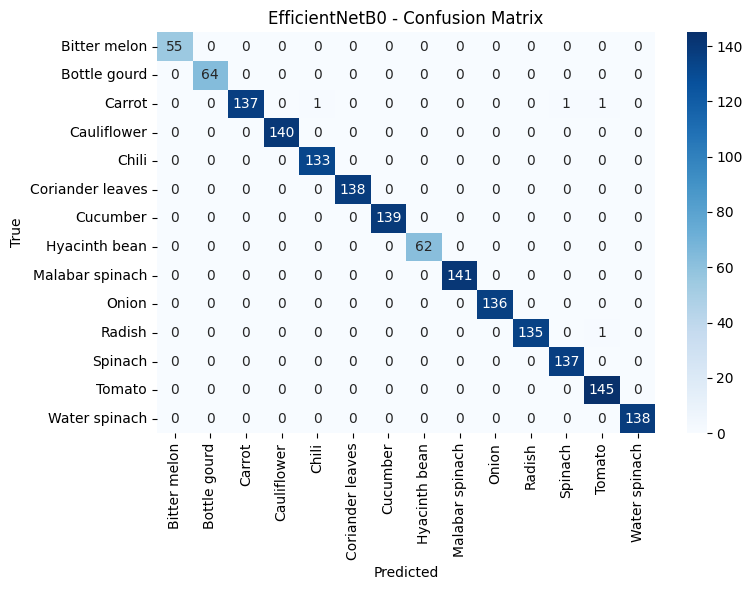

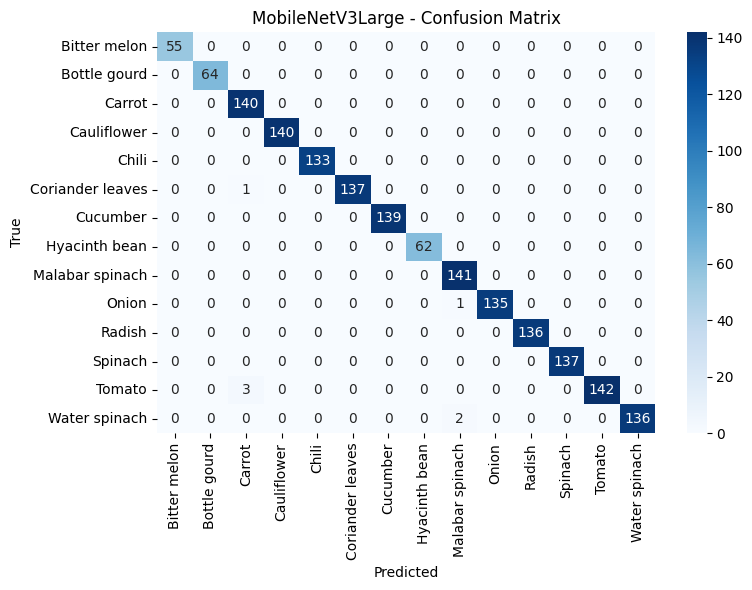

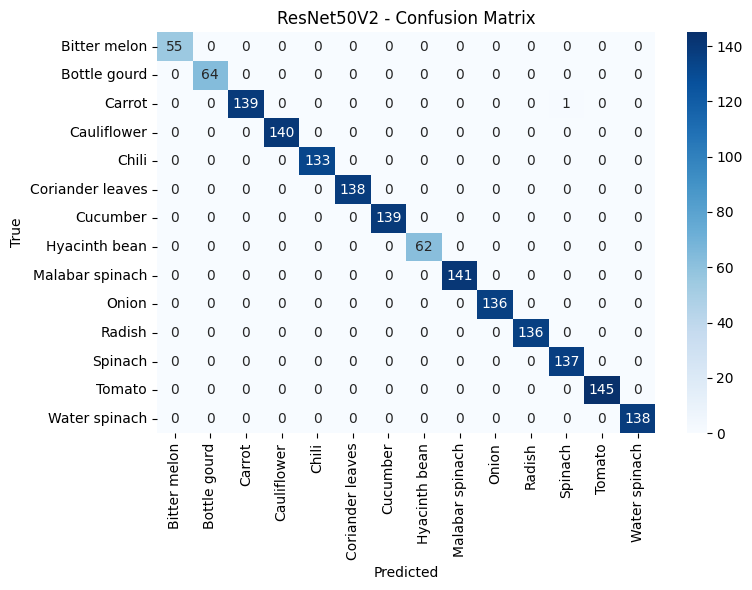

In [22]:
import seaborn as sns

def plot_cm(cm, title, class_names):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_cm(res_e['cm'], 'EfficientNetB0 - Confusion Matrix', class_names)
plot_cm(res_m['cm'], 'MobileNetV3Large - Confusion Matrix', class_names)
plot_cm(res_r['cm'], 'ResNet50V2 - Confusion Matrix', class_names)

###Compare models (table)


=== Model Comparison ===
           Model  Accuracy
      ResNet50V2  0.999413
  EfficientNetB0  0.997653
MobileNetV3Large  0.995892


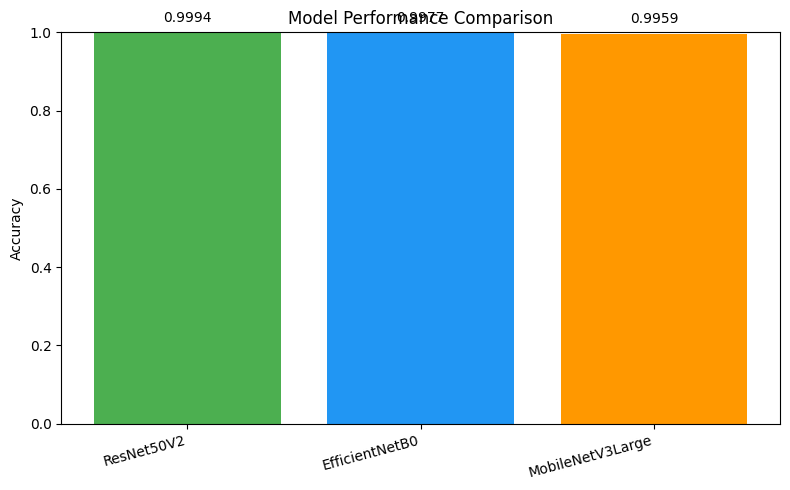

In [23]:
import pandas as pd

compare = pd.DataFrame([
    {'Model': 'EfficientNetB0', 'Accuracy': res_e['acc']},
    {'Model': 'MobileNetV3Large', 'Accuracy': res_m['acc']},
    {'Model': 'ResNet50V2', 'Accuracy': res_r['acc']},
])

compare = compare.sort_values('Accuracy', ascending=False).reset_index(drop=True)
print("\n=== Model Comparison ===")
print(compare.to_string(index=False))

# Visualize comparison
plt.figure(figsize=(8, 5))
plt.bar(compare['Model'], compare['Accuracy'], color=['#4CAF50', '#2196F3', '#FF9800'])
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.ylim([0, 1])
plt.xticks(rotation=15, ha='right')
for i, v in enumerate(compare['Accuracy']):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

###Plot training history

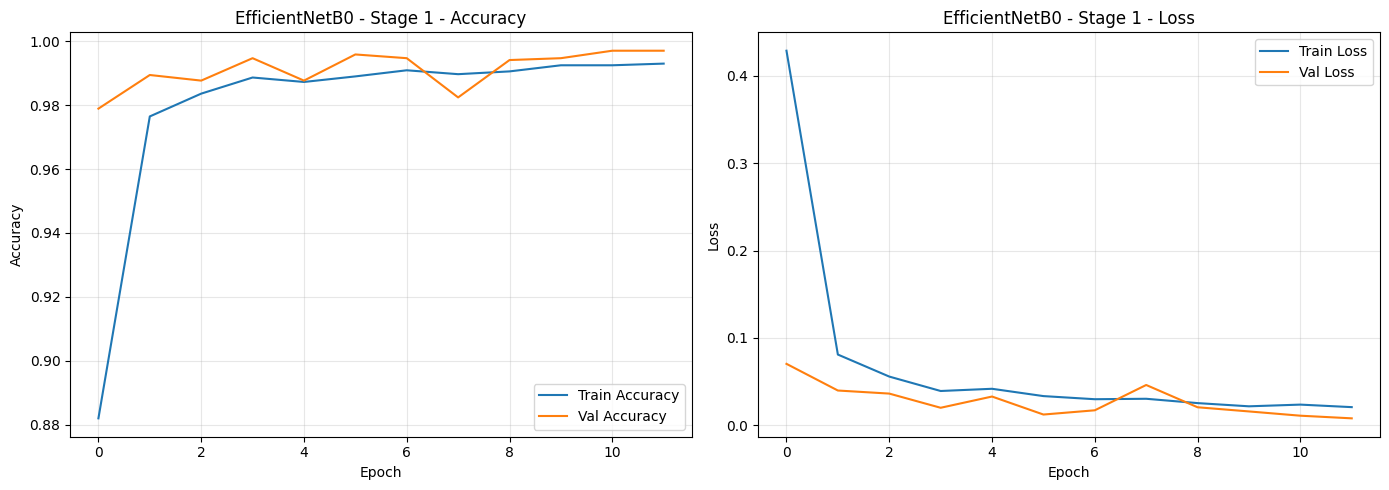

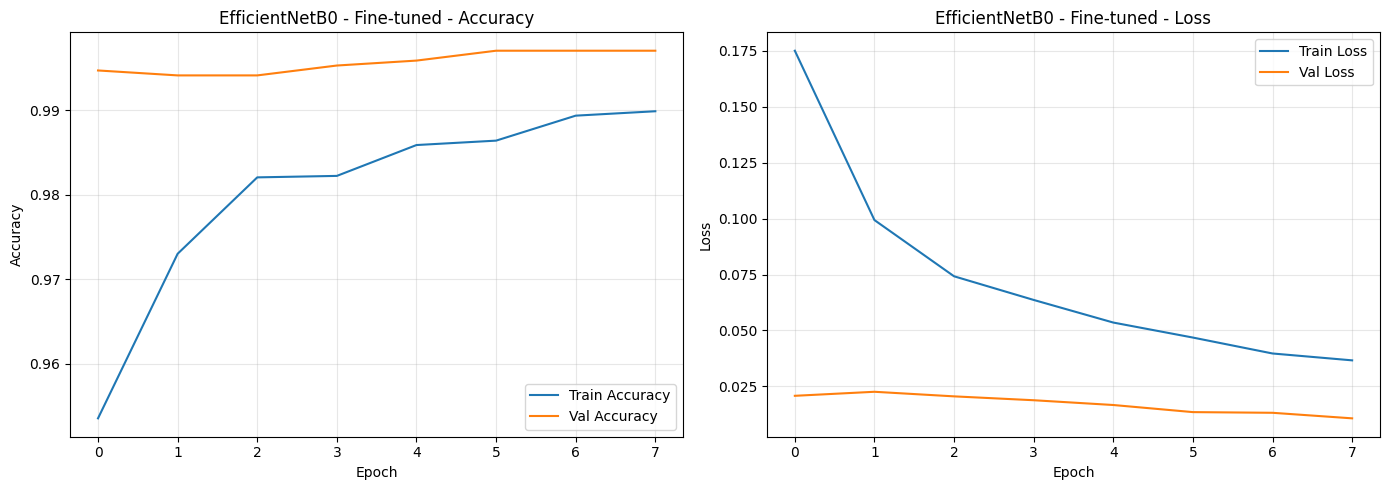

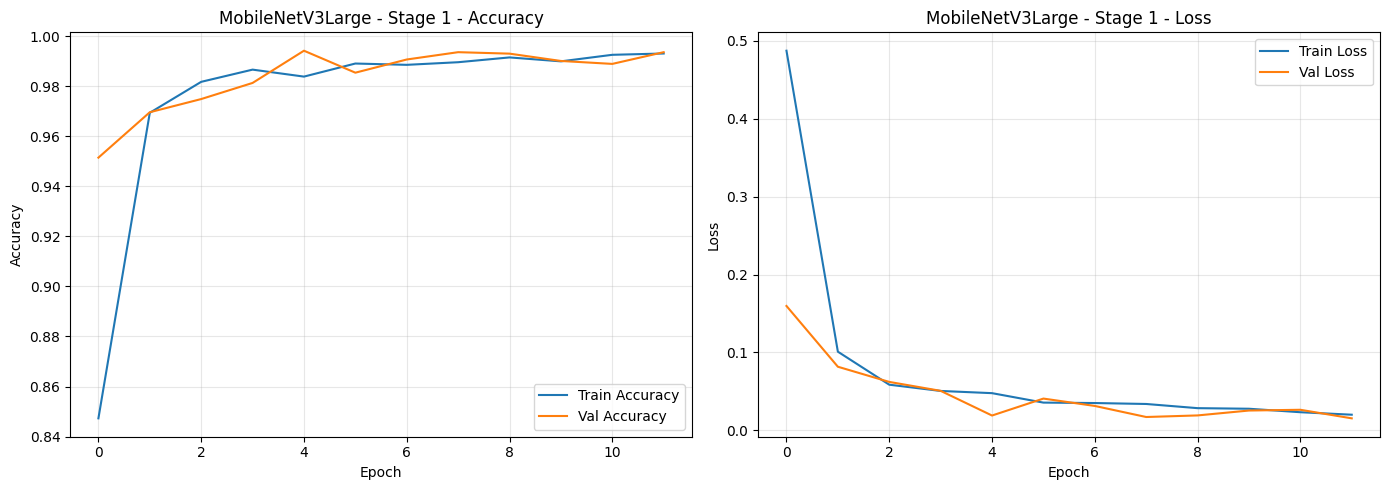

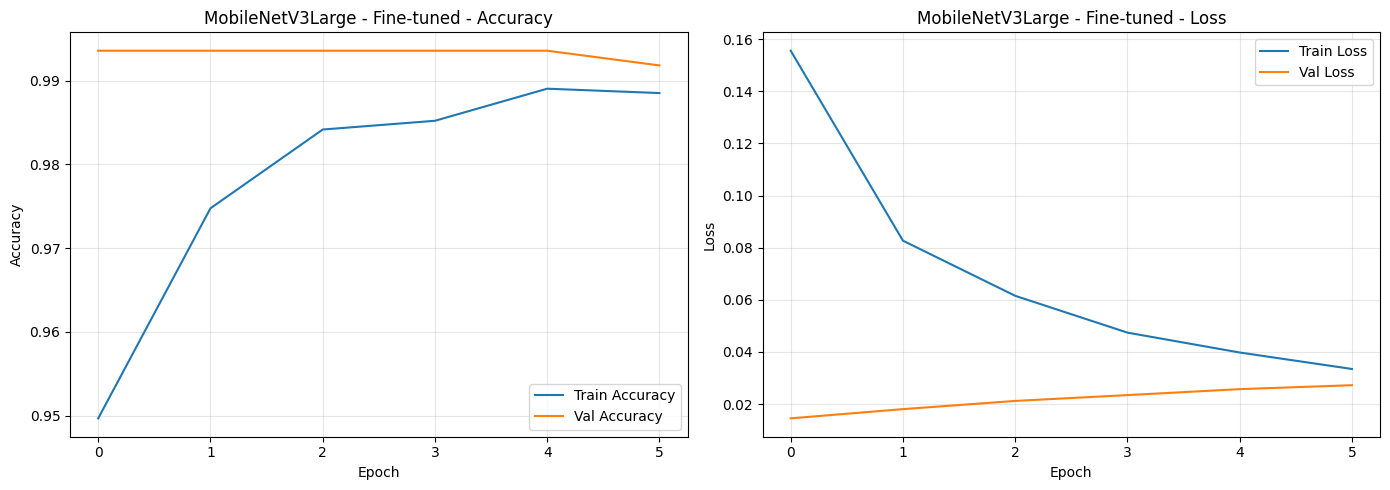

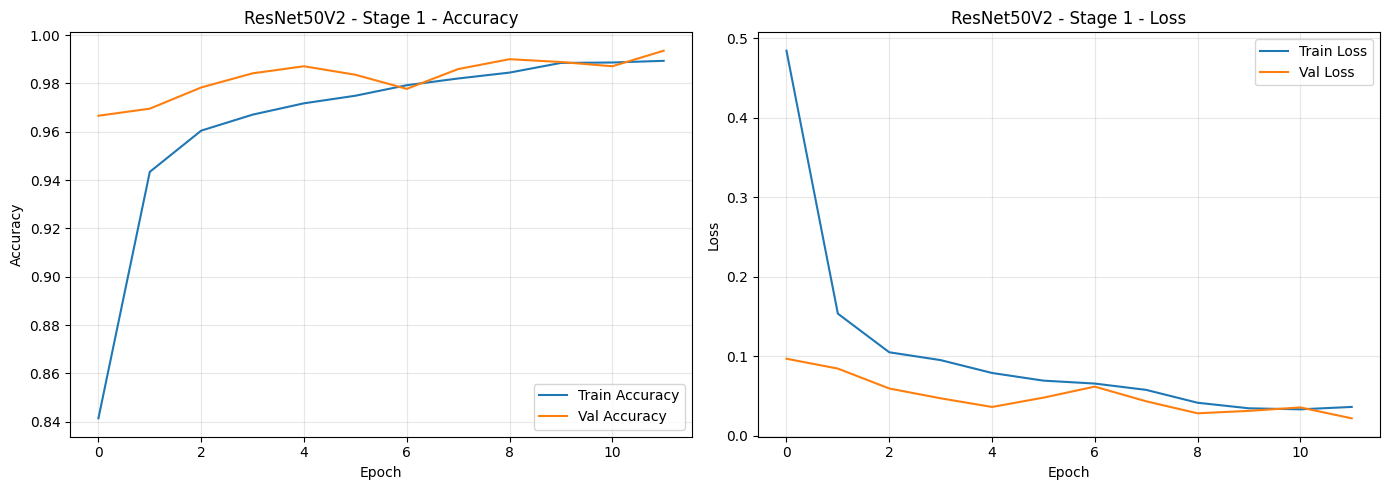

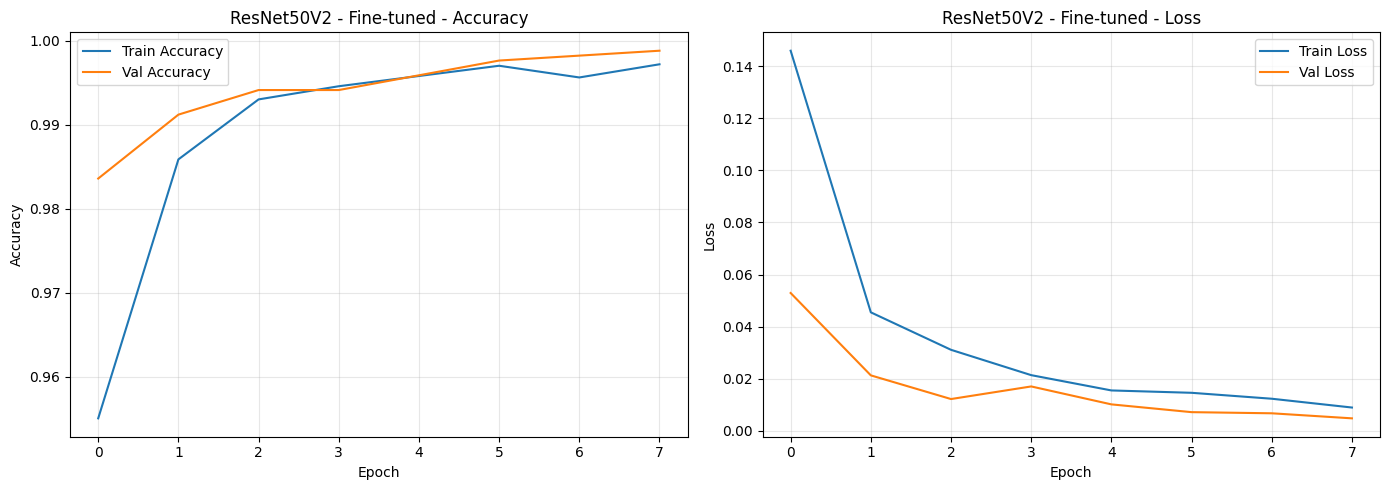

In [24]:
def plot_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_title(f'{title} - Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Val Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title(f'{title} - Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot training history for each model
plot_history(history_e, 'EfficientNetB0 - Stage 1')
plot_history(history_e_ft, 'EfficientNetB0 - Fine-tuned')
plot_history(history_m, 'MobileNetV3Large - Stage 1')
plot_history(history_m_ft, 'MobileNetV3Large - Fine-tuned')
plot_history(history_r, 'ResNet50V2 - Stage 1')
plot_history(history_r_ft, 'ResNet50V2 - Fine-tuned')

###Save the best model

In [25]:
# Determine best model
best_idx = compare['Accuracy'].idxmax()
best_model_name = compare.loc[best_idx, 'Model']
best_acc = compare.loc[best_idx, 'Accuracy']

print(f"\nBest Model: {best_model_name} with Accuracy: {best_acc:.4f}")

# Save best model
if best_model_name == 'EfficientNetB0':
    best_model = model_e
elif best_model_name == 'MobileNetV3Large':
    best_model = model_m
else:
    best_model = model_r

best_model.save('best_seed_classifier.h5')
print("Best model saved as 'best_seed_classifier.h5'")



Best Model: ResNet50V2 with Accuracy: 0.9994
Best model saved as 'best_seed_classifier.h5'


###Test prediction on sample images


Sample predictions from ResNet50V2:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


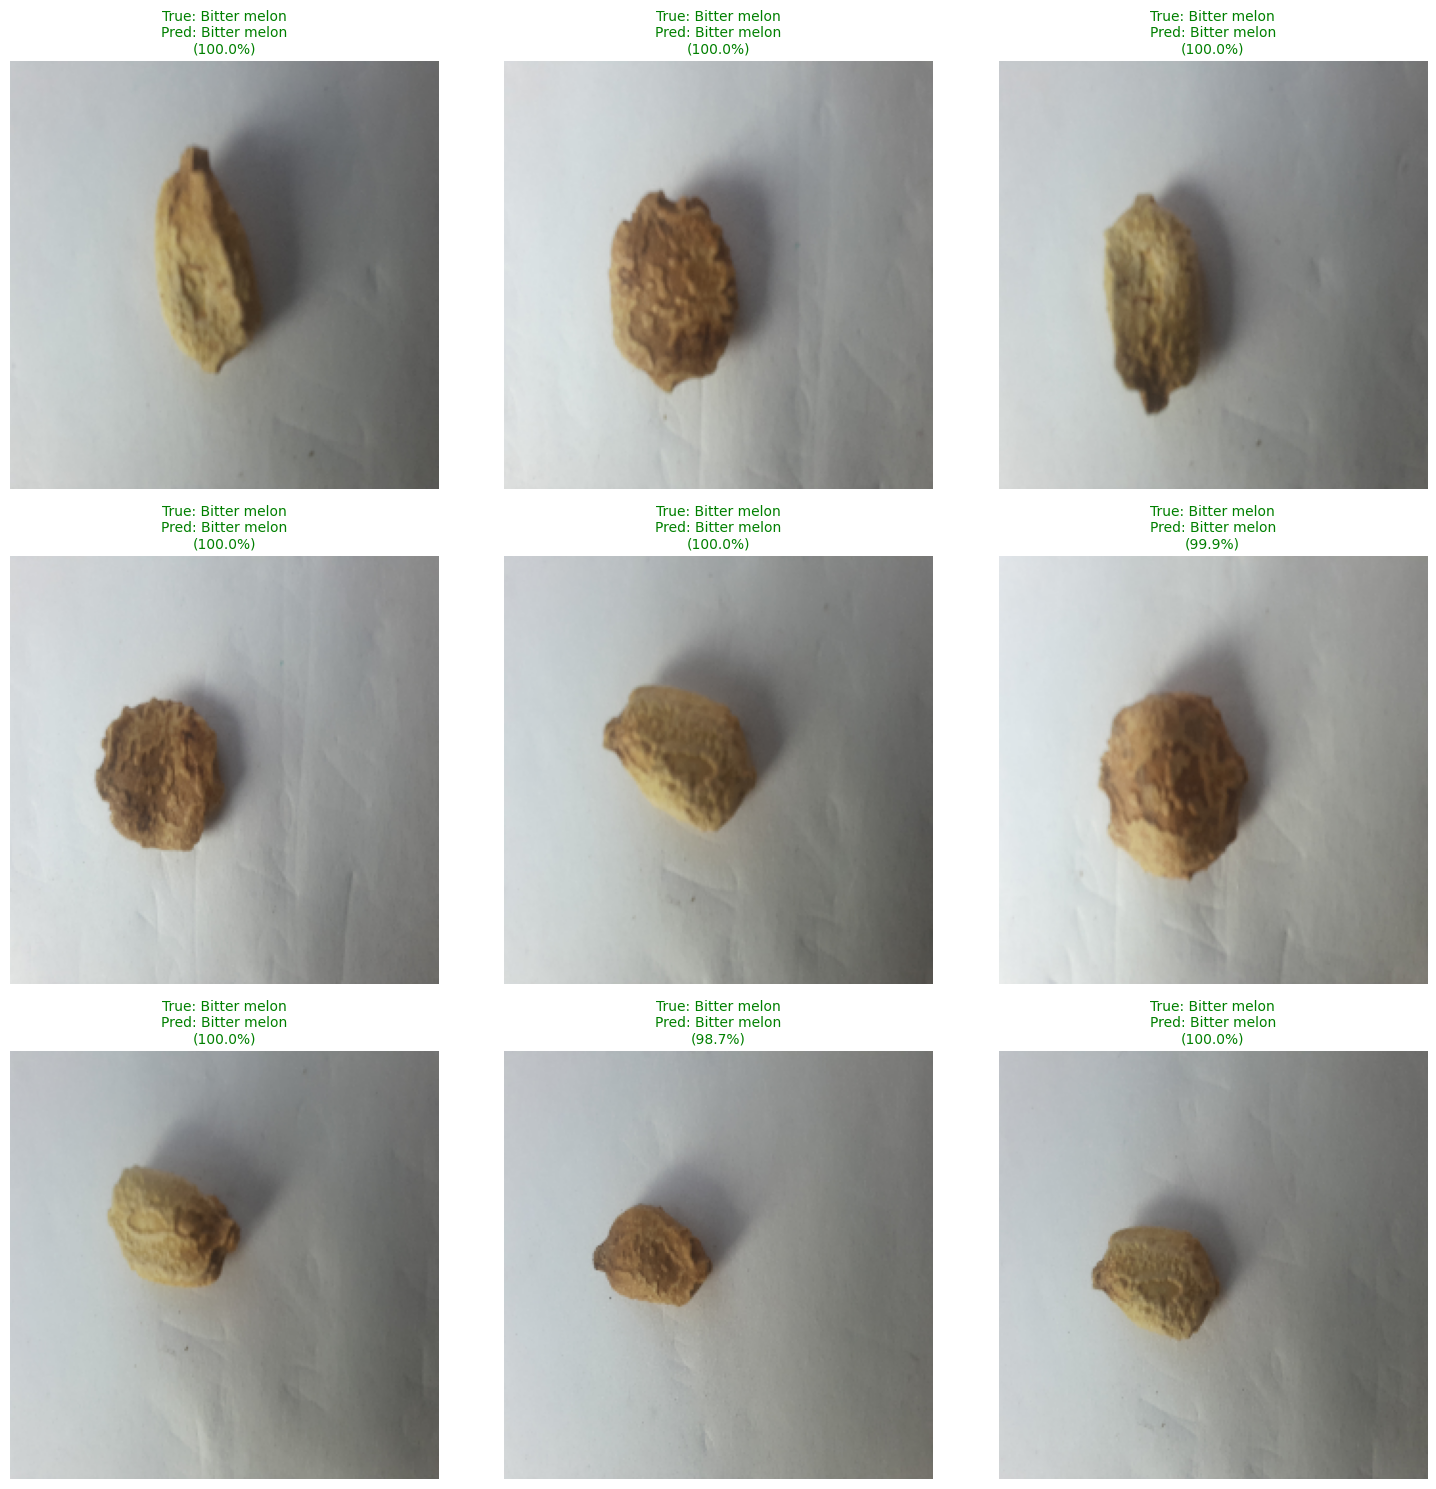

In [26]:
def predict_sample_images(model, test_ds, class_names, num_samples=9):
    """
    Display sample predictions from test set
    """
    # Get one batch
    for images, labels in test_ds.take(1):
        predictions = model.predict(images)
        pred_classes = np.argmax(predictions, axis=1)

        # Plot
        plt.figure(figsize=(15, 15))
        for i in range(min(num_samples, len(images))):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            true_label = class_names[labels[i].numpy()]
            pred_label = class_names[pred_classes[i]]
            confidence = predictions[i][pred_classes[i]] * 100

            color = 'green' if pred_classes[i] == labels[i] else 'red'
            plt.title(f"True: {true_label}\nPred: {pred_label}\n({confidence:.1f}%)",
                     color=color, fontsize=10)
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        break

# Show predictions from best model
print(f"\nSample predictions from {best_model_name}:")
predict_sample_images(best_model, test_ds, class_names)